In [1]:
from scipy.interpolate import LinearNDInterpolator, CloughTocher2DInterpolator, interp2d, NearestNDInterpolator, CubicSpline
from scipy.optimize import fmin, fsolve
from scipy.integrate import quad
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import matplotlib

In [2]:
# Original settings
textwidth = 440  # JCAP uses a textwidth of 440 pts
height = 2
width = textwidth / 72.27
fontsize = 11 / 1.2 * 10 / width

ccc = 'w'
bgc = 'navy'

c_post = 'lime'
c_prof = 'fuchsia'
c_bf = 'orange'

# LaTeX preamble settings
latex_preamble = [
    r'\usepackage{lmodern}',
    r'\usepackage{amsmath}',
    r'\usepackage{amsfonts}',
    r'\usepackage{mathtools}',
    r'\usepackage{siunitx}',
    r'\usepackage{bm}',
    r'\usepackage{xcolor}',
    r'\usepackage[T1]{fontenc}',
]

# Convert the list to a single string, separated by newlines
latex_preamble_str = '\n'.join(latex_preamble)

# Update the matplotlib configuration
plt.rcParams.update({
    'text.usetex': True,
    'font.family': 'serif',
    'font.serif': 'cmr10',
    'font.size': fontsize,
    'mathtext.fontset': 'cm',
    'text.latex.preamble': latex_preamble_str,
})

# Setting additional configurations
plt.rcParams['axes.linewidth'] = 3
plt.rcParams['text.color'] = ccc

In [3]:
def get_profile_lkl(file):
    with open(file,'r') as f:
        f_list = list(f)

    parameters = f_list[0].replace('\n','').split('\t')

    lkl = []
    par_1 = []
    par_2 = []
    for line in f_list[1:]:
        pars = np.float64(line.replace('\n','').split('\t'))
        if pars[2] < 5000.0:
            par_2.append(pars[0])
            par_1.append(pars[1])
            lkl.append(pars[2])
        if pars[2] >= 5000:
            pass#print(file, pars[2])

    post = np.exp(-0.5*np.array(lkl))
    return np.array(par_1), np.array(par_2), np.array(lkl)

In [4]:
def get_profile_lkl_1d(file):
    with open(file,'r') as f:
        f_list = list(f)

    parameters = f_list[0].replace('\n','').split('\t')

    lkl = []
    par = []
    for line in f_list[1:]:
        pars = np.float64(line.replace('\n','').split('\t'))
        if pars[1] < 5000.0:
            par.append(pars[0])
            lkl.append(pars[1])
        if pars[1] >= 5000:
            pass#print(file, pars[1])

    return np.array(par), np.array(lkl)

In [5]:
def get_posterior(file):
    with open(file, 'r') as f:
        f_list = list(f)
    x1=[]
    y1=[]
    x2=[]
    y2=[]
    count = 0
    for line in f_list:
        if line.startswith('#'):
            count += 1
        else:
            if count == 1 and line != '\n':
                xx, yy = np.float64(line.replace('\n','').split('\t'))
                x2.append(xx)
                y2.append(yy)

            if count == 2 and line != '\n':
                xx, yy = np.float64(line.replace('\n','').split('\t'))
                x1.append(xx)
                y1.append(yy)
    return np.array([x1, y1]), np.array([x2, y2])

In [6]:
def get_posterior_1d(file):
    with open(file, 'r') as f:
        f_list = list(f)
    count = 0
    for line in f_list:
        if line.startswith('#'):
            count += 1
        else:
            if count == 2 and line != '\n':
                x = np.float64(line.replace('\n','').split(', '))
            if count == 3 and line != '\n':
                y = np.float64(line.replace('\n','').split(', '))
    return np.array([x, y])

In [7]:

params = ['omega_b',
          'omega_cdm',
          'H0',
          'ln10^{10}A_s',
          'n_s',
          'tau_reio',
          'A_planck'
         ]

latex = [r'$\mathbf{100\times\omega_{\rm b}}$',
         r'$\mathbf{\omega_{\rm cdm}}$',
         r'$\mathbf{H_0}$',
         r'$\mathbf{\log(10^{10}A_s)}$',
         r'$\mathbf{n_s}$',
         r'$\mathbf{\tau_{\rm reio}}$',
         r'$\mathbf{A_{\rm planck}}$'
        ]

In [8]:
from matplotlib.legend_handler import HandlerBase

class Handler_contour(HandlerBase):
    def create_artists(self, legend, orig_handle,
                   xdescent, ydescent, width, height, fontsize,
                   trans):
        a_list = []
        
        t = np.linspace(0,2*np.pi,100)
        
        x1 = (0.5 + 0.25*0.93*np.cos(t))*width - xdescent
        y1 = (0.5 + 0.25*0.93*np.sin(t))*height - ydescent
        
        x2 = (0.5 + 0.5*0.93*np.cos(t))*width - xdescent
        y2 = (0.5 + 0.5*0.93*np.sin(t))*height - ydescent
        
        a_list.append(Line2D(x1,y1))
        a_list.append(Line2D(x2,y2))


        set_attr = []
        get_attr = ['get_alpha','get_antialiased', 'get_c', 'get_color', 'get_dash_capstyle', 'get_dash_joinstyle',
                    'get_fillstyle', 'get_linestyle', 'get_linewidth', 'get_ls', 'get_lw', 'get_marker',
                    'get_markeredgecolor', 'get_markeredgewidth', 'get_markerfacecolor', 'get_markerfacecoloralt',
                    'get_markersize', 'get_ms',  'get_solid_capstyle', 'get_solid_joinstyle', 'get_zorder']
        for at in get_attr:
            set_attr.append('s'+at[1:])

        for a in a_list:
            for gt, st in zip(get_attr, set_attr):
                eval(f"a.{st}(orig_handle.{gt}())")
        return a_list
    
from matplotlib.legend_handler import HandlerBase

class Handler_fill(HandlerBase):
    def create_artists(self, legend, orig_handle,
                   xdescent, ydescent, width, height, fontsize,
                   trans):
        a_list = []
        
        a_list.append(matplotlib.patches.Ellipse((0.5*width-xdescent,0.5*height-ydescent), 1.0*width, 1.0*height, alpha=0.6))
        a_list.append(matplotlib.patches.Ellipse((0.5*width-xdescent,0.5*height-ydescent), 0.5*width, 0.5*height, alpha=1.0))

        set_attr = []
        get_attr = ['get_color']
        for at in get_attr:
            set_attr.append('s'+at[1:])

        for a in a_list:
            for gt, st in zip(get_attr, set_attr):
                eval(f"a.{st}(orig_handle.{gt}())")
        return a_list

class Handler_dots(HandlerBase):
    def create_artists(self, legend, orig_handle,
                   xdescent, ydescent, width, height, fontsize,
                   trans):
        a_list = []
        
        a_list.append(Line2D(np.array([0.2,0.5,0.8])*width - xdescent, np.array([0.5,0.5,0.5])*height - ydescent, marker='.'))
        

        set_attr = []
        get_attr = ['get_alpha','get_antialiased', 'get_c', 'get_color', 'get_dash_capstyle', 'get_dash_joinstyle',
                    'get_fillstyle', 'get_linestyle', 'get_linewidth', 'get_ls', 'get_lw', 'get_marker',
                    'get_markeredgecolor', 'get_markeredgewidth', 'get_markerfacecolor', 'get_markerfacecoloralt',
                    'get_markersize', 'get_ms',  'get_solid_capstyle', 'get_solid_joinstyle', 'get_zorder']
        for at in get_attr:
            set_attr.append('s'+at[1:])

        for a in a_list:
            for gt, st in zip(get_attr, set_attr):
                eval(f"a.{st}(orig_handle.{gt}())")
        return a_list
    
class Handler_line(HandlerBase):
    def create_artists(self, legend, orig_handle,
                   xdescent, ydescent, width, height, fontsize,
                   trans):
        a_list = []
        
        a_list.append(Line2D(np.array([0.1,0.9])*width - xdescent, np.array([0.5,0.5])*height - ydescent))
        

        set_attr = []
        get_attr = ['get_alpha','get_antialiased', 'get_c', 'get_color', 'get_dash_capstyle', 'get_dash_joinstyle',
                    'get_fillstyle', 'get_linestyle', 'get_linewidth', 'get_ls', 'get_lw', 'get_marker',
                    'get_markeredgecolor', 'get_markeredgewidth', 'get_markerfacecolor', 'get_markerfacecoloralt',
                    'get_markersize', 'get_ms',  'get_solid_capstyle', 'get_solid_joinstyle', 'get_zorder']
        for at in get_attr:
            set_attr.append('s'+at[1:])

        for a in a_list:
            for gt, st in zip(get_attr, set_attr):
                eval(f"a.{st}(orig_handle.{gt}())")
        return a_list

/tmp/ipykernel_32015/2577909657.py:12: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, axs = plt.subplots(len(params),len(params), figsize=(10,10))
/tmp/ipykernel_32015/2577909657.py:115: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  Z2 = ndimage.filters.gaussian_filter(Z1,[sigma,sigma], mode='reflect')


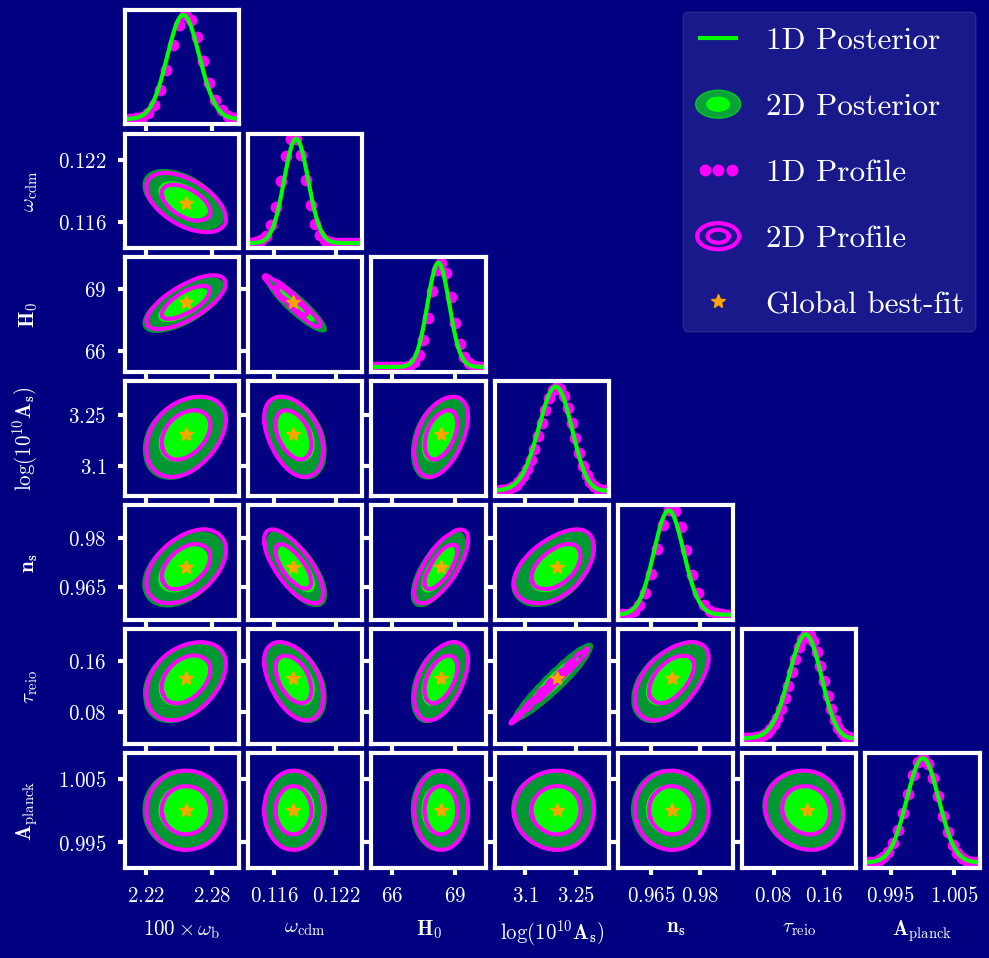

In [11]:
from scipy import ndimage
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

mcmc_base = '/home/lucajn/connect/resources/montepython_public/chains/planck_plus_boss/plots/planck_plus_boss'
#mcmc_base = None
profile_base = '/home/lucajn/connect/lcdm_profiles_bao_boss'

from matplotlib import rc
rc("text", usetex=False)

fig, axs = plt.subplots(len(params),len(params), figsize=(10,10))

with open(profile_base+'/global_bestfit.txt','r') as f:
    f_list = list(f)
bestfit=[]
for val, name in zip(np.float64(f_list[1].strip().split('\t')),f_list[0].strip().split('\t')):
    if name == 'omega_b':
        val *= 100
    if name == 'loglike':
        lkl_min_global = val
    else:
        bestfit.append(val)

ticks = [[2.22,2.28],
         [0.116,0.122],
         [66,69],
         [3.1,3.25],
         [0.965,0.98],
         [0.08,0.16],
         [0.995, 1.005]
         ]


limits = {
          'omega_b':[2.2, 2.305],
          'omega_cdm':[0.1135,0.1245],
          'H0':[65,70.5],
          'ln10^{10}A_s':[3.01,3.35],
          'n_s':[0.955,0.99],
          'tau_reio':[0.03,0.21],
          'A_planck':[0.991,1.009]
          }
posteriors_1d = {}




for i, (par_i, l_i) in enumerate(zip(params, latex)):
    for j, (par_j, l_j) in enumerate(zip(params, latex)):
        axs[j,i].tick_params(width=3,length=5)
        axs[j,i].set_xticks(ticks[i])
        axs[j,i].set_yticks(ticks[j])
        tl=[]
        for t in ticks[i]:
            tl.append(r'$\mathbf{'+str(t)+r'}$')
        axs[j,i].set_xticklabels(tl)
        tl = []
        for t in ticks[j]:
            tl.append(r'$\mathbf{'+str(t)+r'}$')
        axs[j,i].set_yticklabels(tl)
        axs[j,i].tick_params(axis='both', which='major', length=5, width=3)
        
        axs[j,i].xaxis.label.set_color(ccc)
        axs[j,i].yaxis.label.set_color(ccc)
        axs[j,i].tick_params(axis='x', colors=ccc)
        axs[j,i].tick_params(axis='y', colors=ccc)
        axs[j,i].spines['left'].set_color(ccc)
        axs[j,i].spines['top'].set_color(ccc)
        axs[j,i].spines['right'].set_color(ccc)
        axs[j,i].spines['bottom'].set_color(ccc)
        axs[j,i].set_facecolor(bgc)

        if i == j:
            axs[j,i].set_yticks([])
            axs[j,i].set_yticklabels([])
            filename = profile_base + f'/{par_i}.txt'
            p, lkl = get_profile_lkl_1d(filename)
            if par_i == 'omega_b':
                p *= 100
            lkl = np.exp(-np.array(lkl))
            axs[i,i].plot(p,lkl/np.max(lkl),'.', c=c_prof, ms=15, zorder=1)
            
            if mcmc_base is not None:
                filename = mcmc_base+f'_{par_i}.hist'
                dat = get_posterior_1d(filename)
                posteriors_1d[par_i] = dat

                axs[i,i].plot(dat[0],dat[1],'-', c=c_post, lw=3, zorder=2)
            

            
        elif j > i:
            filename = profile_base + f'/{par_i}-{par_j}.txt'
            pi, pj, lkl = get_profile_lkl(filename)
            lkl_min = np.min(lkl)
            
            if par_j == 'omega_b':
                pi = pi*100
            elif par_i == 'omega_b':
                pj = pj*100
            nn = 100
            if (par_i == 'ln10^{10}A_s' and par_j == 'tau_reio') or (par_i == 'omega_cdm' and par_j == 'H0'):
                nn = 500
            X = np.linspace(min(pi), max(pi), nn)
            Y = np.linspace(min(pj), max(pj), nn)
            X, Y = np.meshgrid(X, Y)
            interp = CloughTocher2DInterpolator(list(zip(pi, pj)), lkl, fill_value=100000, rescale=True)

            Z = interp(X, Y)
            Y1 = ndimage.zoom(Y,4, mode='reflect')
            X1 = ndimage.zoom(X,4, mode='reflect')
            Z1 = ndimage.zoom(Z,4, mode='reflect')
            sigma = 2.
            Z2 = ndimage.filters.gaussian_filter(Z1,[sigma,sigma], mode='reflect')

            c = 'r'
            cs2 = axs[j,i].contour(Y,X,Z,levels=[lkl_min_global+6.18/2],zorder=4,colors=c,linewidths=0)
            cs1 = axs[j,i].contour(Y,X,Z,levels=[lkl_min_global+2.3/2],zorder=4,colors=c,linewidths=0)
            
            p2 = cs2.collections[0].get_paths()[0]
            v2 = p2.vertices
            x2 = v2[:,0]
            y2 = v2[:,1]
            
            p1 = cs1.collections[0].get_paths()[0]
            v1 = p1.vertices
            x1 = v1[:,0]
            y1 = v1[:,1]
            
            
                
            axs[j,i].plot(x1,y1, '-', c=c_prof, lw=3, zorder=2)
            axs[j,i].plot(x2,y2, '-', c=c_prof, lw=3, zorder=2)
            
                             
            #axs[j,i].scatter(pj,pi,s=50, c=lkl, cmap='gist_rainbow')
            bf, = axs[j,i].plot([bestfit[i]],[bestfit[j]],'*', c=c_bf, ms=10, label='Best-fit', zorder=4, clip_on=False)
            if mcmc_base is not None:
                filename = mcmc_base+f'_2d_{par_j}-{par_i}.dat'
                dat1, dat2 = get_posterior(filename)

                axs[j,i].fill(dat2[0],dat2[1],c_post,lw=0, zorder=1, alpha=0.6)
                axs[j,i].fill(dat1[0],dat1[1],c_post,lw=0, zorder=1, alpha=1.0)
                if par_i not in limits:
                    limits[par_i] = axs[j,i].get_xlim()
                if par_j not in limits:
                    limits[par_j] = axs[j,i].get_ylim()
            
            
                
        else:
            axs[j,i].axis('off')
         
            
        if j == len(params)-1:
            axs[j,i].set_xlabel(l_i, labelpad=9)
            axs[j,i].tick_params(axis='x', which='major', pad=8)
        else:
            axs[j,i].set_xticklabels([])
        if i == 0 and j>0:
            axs[j,i].set_ylabel(l_j, labelpad=13)
            axs[j,i].tick_params(axis='y', which='major', pad=8)
        else:
            if i != 1 or j != 0:
                axs[j,i].set_yticklabels([])



for i, par_i in enumerate(params):
    for j, par_j in enumerate(params):
        l1i, l2i = limits[par_i]
        l1j, l2j = limits[par_j]
        if i == j:
            
            axs[i,i].set_xlim([l1i,l2i])

        elif j > i:
            axs[j,i].set_xlim([l1i,l2i])
            axs[j,i].set_ylim([l1j,l2j])
            
        elif j < i:
            axs[j,i].set_xlim([l1i,l2i])
            axs[j,i].set_ylim([l1j,l2j])
      

l1, = axs[1,0].plot([-10000],[875],'-', c=c_post,lw=3)
l2, = axs[1,0].plot([-86576],[3456],'.', c=c_prof,ms=15)
l3, = axs[1,0].plot([-86576],[3456],c_post)
l4, = axs[1,0].plot([-86576],[3456],c_prof, lw=3)

lines = [l1, l3, l2, l4, bf]
#labels = [r'\textbf{1D Planck}', r'\textbf{2D Planck}',r'\textbf{1D Planck+BAO}', r'\textbf{2D Planck+BAO}', r'\textbf{Global best-fit}']
labels = ['1D Posterior', '2D Posterior','1D Profile', '2D Profile', 'Global best-fit']
if mcmc_base is None:
    lines = [lines[2], lines[3], lines[4]]
    labels = [labels[2], labels[3], labels[4]]


plt.subplots_adjust(wspace=0.08,
                    hspace=0.08,
                    left=0.14,                                                                                 
                    bottom=0.13,
                    right=0.995,
                    top=0.988)

l = plt.legend(lines, labels,
               bbox_to_anchor=(1.01,7.5,0.1,0.1),
               ncol=1, handler_map={l4:Handler_contour(), l3:Handler_fill(), l2:Handler_dots(), l1: Handler_line()},
               handlelength=1.44, handleheight=1, labelspacing = 1.123,
               framealpha=0.1, fontsize=fontsize*1.5)
for text in l.get_texts():
    text.set_color(ccc)

fig.set_facecolor(bgc)

l.get_frame().set_linewidth(15/width/2)
fig.align_ylabels(axs[:,0])
plt.savefig('2d_prof_plus_post_boss.pdf')